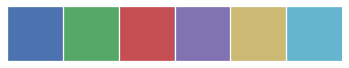

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.animation import FuncAnimation
from tempfile import NamedTemporaryFile
from IPython.display import HTML
import seaborn as sns
import numpy as np
import six
import tensorflow as tf

plt.style.use('seaborn-talk')
sns.set_context("talk", font_scale=1.4)
# sns.set_palette("colorblind")
sess = ed.get_session()

sns.palplot(sns.color_palette())

In [2]:
ed.set_seed(42)

In [3]:
from edward.models import Bernoulli, Empirical, Beta, Uniform, Normal

In [4]:
N = 200
# No prior here, just the real value
# Work with tensors until you do something
def build_fair_dataset(N):
    pheads = tf.constant(0.5)
    c = Bernoulli(probs = pheads, sample_shape = N)
    return sess.run([pheads, c])

def build_unknown_dataset(N):
    pheads = Beta(0.0, 1.0)
    c = Bernoulli(probs = pheads, sample_shape = N)
    return sess.run([pheads, c])

# BUILD TWO DATASETS
pheads_true, c_train = build_fair_dataset(N)
#pheads_unknown, c = build_dataset(N)

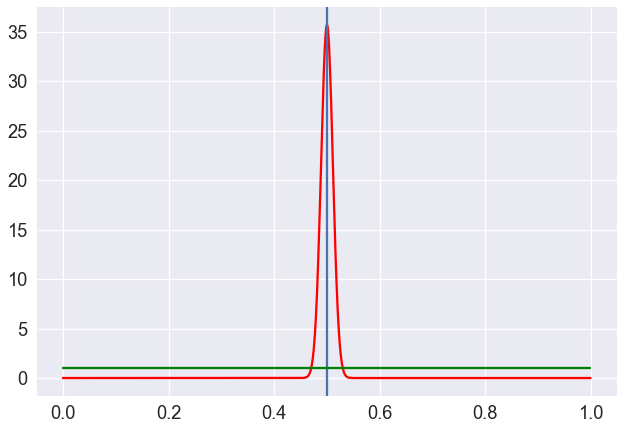

In [5]:
# PLOT PRIOR OF ALMOST CERTAINTY
pheads_fair = Beta(1000.0, 1000.0)
x = tf.range(0.0, 1.0, 0.001)
plt.plot(*sess.run([x, pheads_fair.prob(x)]), 'red')
plt.axvline(x = pheads_true)


## NOW ASSUME you don't know much about your coin, add a uniform 1,1 prior and create your supposed model
pheads_unknown = Beta(1.0, 1.0)
plt.plot(*sess.run([x, pheads_unknown.prob(x)]), 'green')
c = Bernoulli(probs = pheads_unknown, sample_shape = N)

# Exact Inference

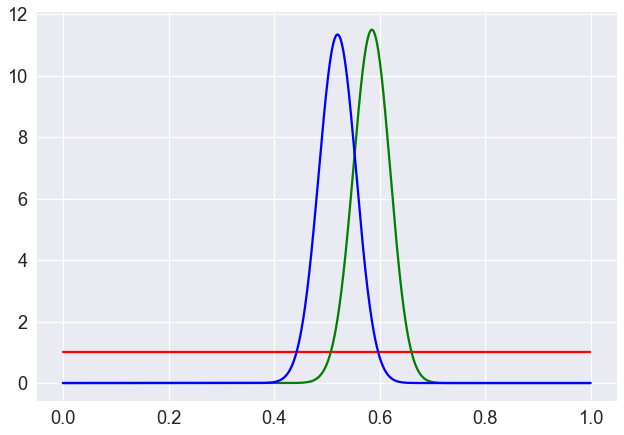

In [6]:
# What we do next is find the conditional probability of heads and then finding the posterior
pheads_cond = ed.complete_conditional(pheads_unknown)
pheads_post = ed.copy(pheads_cond, {c:c_train})

# Check how the prior, likelihood and posterior look like. 
plt.plot(*sess.run([x, pheads_unknown.prob(x)]), 'red') # prior
plt.plot(*sess.run([x, pheads_cond.prob(x)]), 'green')  # Likelihood 
plt.plot(*sess.run([x, pheads_post.prob(x)]), 'blue')   # posterior

In [7]:
# I don't know how this piece of code works mainly because of the six, or what it does 
# I have a feeling it's adjusting the new prior? 
sess.run({key: val for
          key, val in six.iteritems(pheads_post.parameters)
          if isinstance(val, tf.Tensor)})

# CRITICISM: how good is the model? if it wouldn't be solved exactly, we'd have to iterate with MCMC or VI
mean, stddev = sess.run([pheads_post.mean(), pheads_post.stddev()])
print('Posterior mean:', mean)
print('Posterior stddev:', stddev)

Posterior mean: 0.519802
Posterior stddev: 0.035065588


# Metropolis-Hastings

/Users/patricfulop/anaconda3/envs/edward_tensorflow/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/Users/patricfulop/anaconda3/envs/edward_tensorflow/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


10000/10000 [100%] ██████████████████████████████ Elapsed: 13s | Acceptance Rate: 0.114
Inferred posterior mean: 0.5204039
Inferred posterior std: 0.035784893


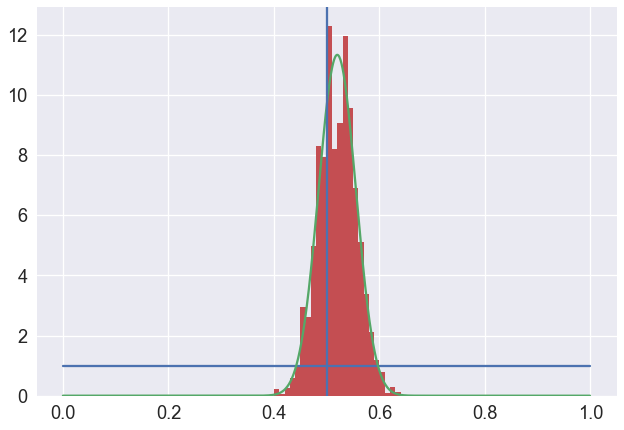

In [8]:
# Metropolis - Hastings
T = 10000
q_pheads = Empirical(params=tf.Variable(tf.ones([T])*0.5))

proposal_heads = Beta(1.0, 1.0)

inference = ed.MetropolisHastings(latent_vars = {pheads_unknown:q_pheads}, # posterior, bind the empirical to the unknown posterior
                                    proposal_vars ={pheads_unknown: proposal_heads}, # bind vars to proposal  
                                    data = {c:c_train}) # likelihood
inference.run()

mean, stddev = sess.run([q_pheads.mean(), q_pheads.stddev()])
print("Inferred posterior mean:", mean)
print("Inferred posterior std:", stddev)

#plt.plot(q_pheads.params.eval());
#plt.axhline(y=pheads_true);

# Doesn't perform so well, the green line is the likelihood and you can see the accepted q's how they fit the likelihood.
x = tf.range(0.0, 1.0, 0.001)
plt.plot(*sess.run([x, pheads_unknown.prob(x)]));  # blue
plt.plot(*sess.run([x, pheads_cond.prob(x)],  # green
                   {c: c_train}));
plt.hist(q_pheads.params.eval(),  # red
         bins=100, range=(0.0, 1.0),
         normed=True);
plt.axvline(x=pheads_true);  # blue

# Gibbs

/Users/patricfulop/anaconda3/envs/edward_tensorflow/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/Users/patricfulop/anaconda3/envs/edward_tensorflow/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


10000/10000 [100%] ██████████████████████████████ Elapsed: 17s | Acceptance Rate: 1.000
Inferred posterior mean: 0.5199229
Inferred posterior std: 0.035085555


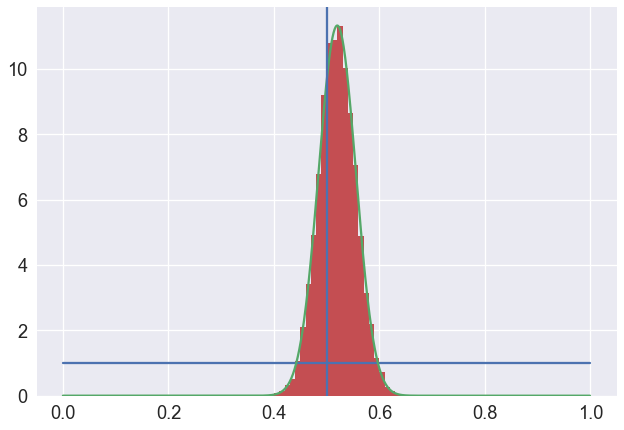

In [9]:
# Gibbs now, does it do better? 
T = 10000
q_pheads = Empirical(params=tf.Variable(tf.ones([T])*0.5))

# No proposal needed for Gibbs

inference = ed.Gibbs(latent_vars = {pheads_unknown:q_pheads}, # posterior, bind the empirical to the unknown posterior
                                    data = {c:c_train}) # likelihood
inference.run()

mean, stddev = sess.run([q_pheads.mean(), q_pheads.stddev()])
print("Inferred posterior mean:", mean)
print("Inferred posterior std:", stddev)

#plt.plot(q_pheads.params.eval()); to view the chain
#plt.axhline(y=pheads_true);
# use lags to plot the autocorrelation - see the notebook from Pycon for lags 

# Doesn't perform so well, the green line is the likelihood and you can see the accepted q's how they fit the likelihood.
x = tf.range(0.0, 1.0, 0.001)
plt.plot(*sess.run([x, pheads_unknown.prob(x)]));  # blue
plt.plot(*sess.run([x, pheads_cond.prob(x)],  # green
                   {c: c_train}));
plt.hist(q_pheads.params.eval(),  # red
         bins=100, range=(0.0, 1.0),
         normed=True);
plt.axvline(x=pheads_true);  # blue

# Hamiltonian Monte Carlo

10000/10000 [100%] ██████████████████████████████ Elapsed: 59s | Acceptance Rate: 1.000
Inferred posterior mean: 0.519829
Inferred posterior std: 0.0334278


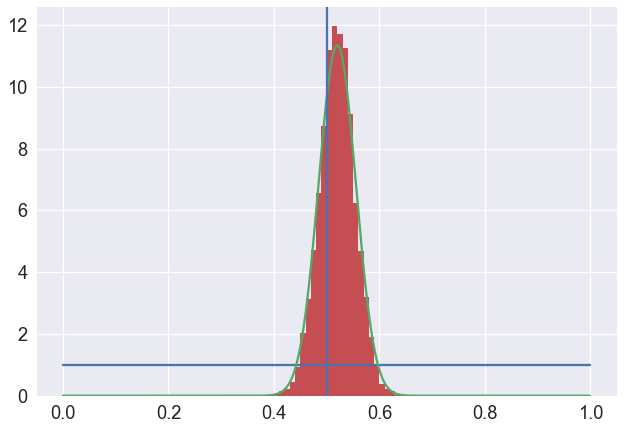

In [18]:
# HMC best one for high dimension, continous variables and non-tractable complete conditional
T = 10000
q_pheads = Empirical(params=tf.Variable(tf.ones([T])*0.5))

# No proposal needed for HMC

inference = ed.HMC(latent_vars = {pheads_unknown:q_pheads}, # posterior, bind the empirical to the unknown posterior
                                    data = {c:c_train}) # likelihood
inference.run(step_size=1.0 / N, n_steps=20)

mean, stddev = sess.run([q_pheads.mean(), q_pheads.stddev()])
print("Inferred posterior mean:", mean)
print("Inferred posterior std:", stddev)

#plt.plot(q_pheads.params.eval()); to view the chain
#plt.axhline(y=pheads_true);
# use lags to plot the autocorrelation - see the notebook from Pycon for lags 

# Doesn't perform so well, the green line is the likelihood and you can see the accepted q's how they fit the likelihood.
x = tf.range(0.0, 1.0, 0.001)
plt.plot(*sess.run([x, pheads_unknown.prob(x)]));  # blue
plt.plot(*sess.run([x, pheads_cond.prob(x)],  # green
                   {c: c_train}));
plt.hist(q_pheads.params.eval(),  # red
         bins=100, range=(0.0, 1.0),
         normed=True);
plt.axvline(x=pheads_true);  # blue

# Bayesian Linear Regression

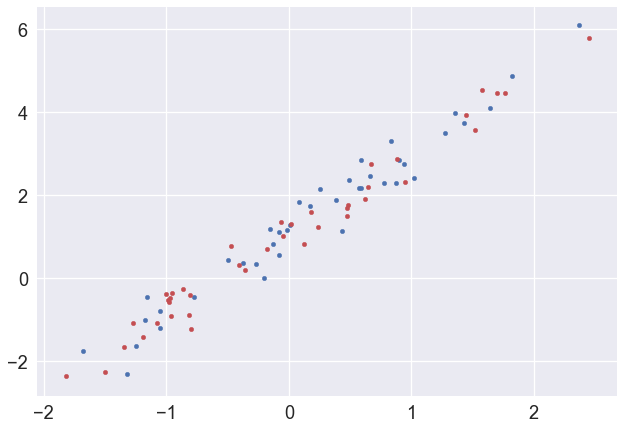

In [11]:
# Artificial data in 1-D and 10-D, I don't really know how to visualize in 10D
N = 40
Ntest = 40
D = 1 # features or dimensions

# Some predefined weights so you can build the artificial points.
weights_true = sess.run(Normal(loc=tf.ones(D) * 2.0,
                               scale=tf.ones(D) * 0.1))  # unknown true weights
intercept_true = sess.run(Normal(loc=tf.zeros(1),
                                 scale=tf.ones(1)))  # unknown true intercept
noise_true = 0.35  # unknown true amount of noise

def build_dataset(N):
    x = Normal(loc=tf.zeros([N, D]), scale=tf.ones([N, D]))
    y = Normal(loc=ed.dot(x, weights_true) + intercept_true, scale=noise_true)
    return sess.run([x, y])

x_train1, y_train1 =  build_dataset(N)
x_test, y_test = build_dataset(Ntest)

plt.scatter(x_train1, y_train1, s=20.0);  # blue
plt.scatter(x_test, y_test, s=20.0,
            color=sns.color_palette().as_hex()[2]);  # red

In [12]:
# Model specification 
x = tf.placeholder(tf.float32, [N, D]) 
w = Normal(loc=tf.zeros(D), scale=tf.ones(D)) # prior on weights is normal with mean 0 and stddev 1 
b = Normal(loc=tf.zeros(1), scale=tf.ones(1)) # prior on intercept same as weights
# MODEL likelihood 
y = Normal(loc=ed.dot(x, w) + b, scale=tf.ones(N)*1.0)  # add some noise to the model 0.01, 0.5 or 1.0

#x = tf.range(0.0, 1.0, 0.001)
#plt.plot(*sess.run([x, pdf.prob(x)]));

In [15]:
# INFERENCE
# 1) HMC
T = 10000 
q_w = Empirical(params = tf.Variable(tf.zeros([T,D]))) # 10000 samples and D dimensions
q_b = Empirical(params = tf.Variable(tf.zeros([T,1]))) 

inference_HMC = ed.HMC(latent_vars = {w:q_w, b:q_b}, data = {x:x_train1, y: y_train1})
inference_HMC.run(step_size = 0.01/N, n_steps = 20)

# 2) VI  
#qw = Normal(loc=tf.Variable(tf.random_normal([D])), scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
#qb = Normal(loc=tf.Variable(tf.random_normal([1])), scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

#inference_VI = ed.KLqp({w: qw, b: qb}, data={x: x_train1, y: y_train1})
#inference_VI.run(n_samples=5, n_iter=250)

# 3) Analytical - should be able to solve analytically 
# Cannot find conjugate likelihood for normal, need to specify what the condition on?
#conditional_w = ed.complete_conditional(w)
#conditional_b = ed.complete_conditional(b)
#weight_posterior = ed.copy(conditional_w,conditional_b, {x:x_train1, y:y_train1})


/Users/patricfulop/anaconda3/envs/edward_tensorflow/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


10000/10000 [100%] ██████████████████████████████ Elapsed: 38s | Acceptance Rate: 1.000


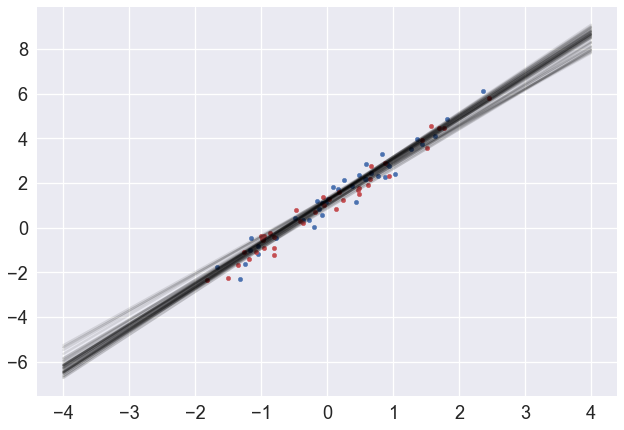

In [16]:
# Criticize or see what you've inferred
plt.scatter(x_train1, y_train1, s=20.0);  # blue
plt.scatter(x_test, y_test, s=20.0,
            color=sns.color_palette().as_hex()[2]);  # red

# This next plotting is cool - looks like the best way to check what you've done is good. The point estimates
# don't really tell you much. There needs to be some benchmark for problems where you can't display the data. 
xp = tf.placeholder(tf.float32, [2, D])
[plt.plot(np.linspace(-4.0, 4.0, 2),
          sess.run(ed.dot(xp, q_w.params[t]) + q_b.params[t],
                   {xp: np.linspace(-4.0, 4.0, 2)[:, np.newaxis]}),
          color='black', alpha=0.1)
 for t in range(int(T/2), T, int(T/100))];

In [17]:
y_post_predictive = ed.copy(y, {w: q_w,
                     b: q_b})
# y_post = Normal(x,qw,qb)

print("Mean squared error on test data:", ed.evaluate('mean_squared_error', data={x: x_test, y_post_predictive: y_test}))

print("Mean absolute error on test data:", ed.evaluate('mean_absolute_error', data={x: x_test, y_post_predictive: y_test}))

#ed.evaluate('categorical_accuracy', data = {y_post_predictive:y_train1, x:x_train1})

/Users/patricfulop/anaconda3/envs/edward_tensorflow/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


Mean squared error on test data: 0.24544625
Mean absolute error on test data: 0.38905525
